# Exponential distribution of residence times

In [1]:

# Filter warnings (before imports)
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
import pkg_resources # Must be placed after DeprecationWarning as it is itself deprecated
warnings.filterwarnings('ignore', message='.*pkg_resources.*')
warnings.filterwarnings('ignore', message='.*declare_namespace.*')

# Libraries installed by default
import sys
import os

# Libraries need to be installed if not
import numpy as np
import pandas as pd

# Libraries added from 'conda install' procedure
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import rasterio
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
import flopy
import flopy.utils.binaryfile as fpu
import imageio
from osgeo import gdal # Error warnings to fix
from scipy.optimize import curve_fit

import whitebox
wbt = whitebox.WhiteboxTools()
wbt.verbose = True



/home/agauvain/anaconda3/envs/hmp/lib/python3.8/site-packages/osgeo/__init__.py:8: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [2]:

from os.path import dirname, abspath
root_dir = '/home/agauvain/Git/HydroModPy'
sys.path.append(root_dir)
print("Root path directory is: {0}".format(root_dir.upper()))



Root path directory is: /HOME/AGAUVAIN/GIT/HYDROMODPY


In [3]:

import src
import importlib
importlib.reload(src)

# Import HydroModPy modules
from src import watershed_root
from src.display import visualization_results, export_vtuvtk
from src.tools import toolbox, folder_root

fontprop = toolbox.plot_params(8,15,18,20) # small, medium, interm, large

def select_period(df, first, last):
    df = df[(df.index.year>=first) & (df.index.year<=last)]
    return df



In [4]:

example_path = os.path.join(root_dir, "examples", "08_exponential distribution of residence times/")
data_path = os.path.join(example_path, "data/")

# The folder out_path is created in the example_path root directory:
out_path = os.path.join(root_dir,'examples', 'results')
# Or define it manually
# out_path = 'C:/Simulations/HydroModPy/'

print('The results of the example will be saved here :', out_path)



The results of the example will be saved here : /home/agauvain/Git/HydroModPy/examples/results


In [5]:

dL_fact = 0.01              # ratio between thickness and lenght of the aquifer d/L
dx = 10                     # discretization in the x-axis
part_num = 1                # particle number per cell
tracking_dir = 'forward'    # 'backward'

model_name = 'test_v1'



In [6]:

case = 'Example_08_Synthetic'         #name of the folder in examples folder

if case == 'Example_08_Synthetic':
    dem_path_ref = data_path + 'hillslope_1D.tif'
    
    resamp_res = dx
    dem_path_res = data_path + 'hillslope_1D_resampled'+str(resamp_res)+'.tif'
    
    if not os.path.exists(dem_path_res):
        # open reference file and get resolution
        x_res = resamp_res
        y_res = resamp_res  # make sure this value is positive
        # specify input and output filenames
        inputFile = dem_path_ref
        outputFile = dem_path_res
        # call gdal Warp
        kwargs = {"format": "GTiff", "xRes": x_res, "yRes": y_res}
        ds = gdal.Warp(outputFile, inputFile, **kwargs)
        del(ds)
        
    x = imageio.imread(dem_path_res)
    x = (x*0)+1000*dL_fact
    toolbox.export_tif(dem_path_res, x, data_path + 'hillslope_1D_userdefined.tif', -99999)
    dem_path = data_path + 'hillslope_1D_userdefined.tif'
    
    load = False
    watershed_name = case
    from_lib = None # os.path.join(root_dir,'watershed_library.csv')
    from_dem = [dem_path, 10] # [path, cell size]
    from_shp = None # [path, buffer size]
    from_xyv = None # [x, y, snap distance, buffer size]
    bottom_path = None # path
    modflow_path = os.path.join(root_dir,'bin/')
    save_object = True
    


In [7]:

print('##### '+watershed_name.upper()+' #####')

# load = True
BV = watershed_root.Watershed(dem_path=dem_path,
                              out_path=out_path,
                              load=load,
                              watershed_name=watershed_name,
                              from_lib=from_lib, # os.path.join(root_dir,'watershed_library.csv')
                              from_dem=from_dem, # [path, cell size]
                              from_shp=from_shp, # [path, buffer size]
                              from_xyv=from_xyv, # [x, y, snap distance, buffer size]
                              bottom_path=bottom_path, # path 
                              save_object=save_object)

# Paths generated automatically but necessary for plots
stable_folder = out_path+'/'+watershed_name+'/'+'results_stable/'
simulations_folder = out_path+'/'+watershed_name+'/'+'results_simulations/'



##### EXAMPLE_08_SYNTHETIC #####
      __  __          __           __  ____          ________     
     / / / /         / /          /  \/   /         / / __  /     
    / /_/ /_  ______/ /________  /       /___  ____/ / /_/ /_  __ 
   / __  / / / / __  / ___/ __ \/ /\,-/ / __ \/ __  / ____/ / / / 
  / / / / /_/ / /_/ / /  / /_/ / /   / / /_/ / /_/ / /   / /_/ /  
 /_/ /_/\__, /_____/_/   \____/_/   /_/\____/_____/_/____\__, /   
       /____/ Hydrological Modelling in Python /_____________/    
                                                                  
Python object was not loaded as requested; it was created from scratch
Extract geography of the model area


In [8]:

# Frame settings
box = True # or False
sink_fill = False # or True
sim_state = 'steady' # 'steady' or 'transient'
plot_cross = False
dis_perlen =  True
check_grid = True

# Ratio to reach 
KR = 15000 # hydraulic conductivity divided by recharge
# KR = 10 # hydraulic conductivity divided by recharge

# Climatic settings
recharge = 1 / 1000 # 33 mm/day
first_clim = 'mean'

# Hydraulic settings
hk = KR * recharge
nlay = 10
lay_decay = 1 # 1 for no decay
bottom = 0 # elevation in meters, None for constant auifer thickness, or 2D matrix
thick = 1000*dL_fact # if bottom is None, aquifer thickness
hk_decay = 0 # exponential decay : 1/20 (half decrease at 20m)
cond_drain = 0 # if 0, DRN is not actvated, with None: linked to hk value of the first layer
sy = 10 / 100 # -
ss = 1e-10

# Boundary settings
bc_left = 5 # or value
# bc_left = thick # or value
bc_right = None # or value
sea_level = 'None' # or value based on specific data : BV.oceanic.MSL



In [9]:

# Import modules
BV.add_settings()
BV.add_climatic()
BV.add_hydraulic()

# Frame settings
BV.settings.update_model_name(model_name)
BV.settings.update_box_model(box)
BV.settings.update_sink_fill(sink_fill)
BV.settings.update_simulation_state(sim_state)
BV.settings.update_check_model(plot_cross=plot_cross, check_grid=check_grid)

# Climatic settings
BV.climatic.update_recharge(recharge, sim_state=sim_state)
BV.climatic.update_first_clim(first_clim)

# Hydraulic settings
BV.hydraulic.update_nlay(nlay) # 1
BV.hydraulic.update_lay_decay(lay_decay) # 1
BV.hydraulic.update_bottom(bottom) # None
BV.hydraulic.update_thick(thick) # 30 / intervient pas si bottom != None
BV.hydraulic.update_hk(hk)
BV.hydraulic.update_sy(sy)
BV.hydraulic.update_ss(ss)

# Boundary settings
BV.settings.update_bc_sides(bc_left, bc_right)
BV.add_oceanic(sea_level)
BV.settings.update_dis_perlen(dis_perlen)



Init settings module to set model parameter
Init climatic module to set model parameter
Init hydraulic module to set model parameter


Check model grid: all cells satisfy the water flow connectivity condition
FloPy is using the following executable to run the model: ../../../../../bin/linux/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.3.0 07/01/2022                        
                    BASED ON MODFLOW-2005 Version 1.12.0 02/03/2017                       

                    SWR1 Version 1.05.0 03/10/2022                       

 Using NAME file: test_v1.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2025/01/09 13:17:21

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2025/01/09 13:17:22
 Elapsed run time:  0.512 Seconds

  Normal termination of simulation
 Post-processing:  Stress period:    1  /  1
   Export watertable elevation
   Export watertable 

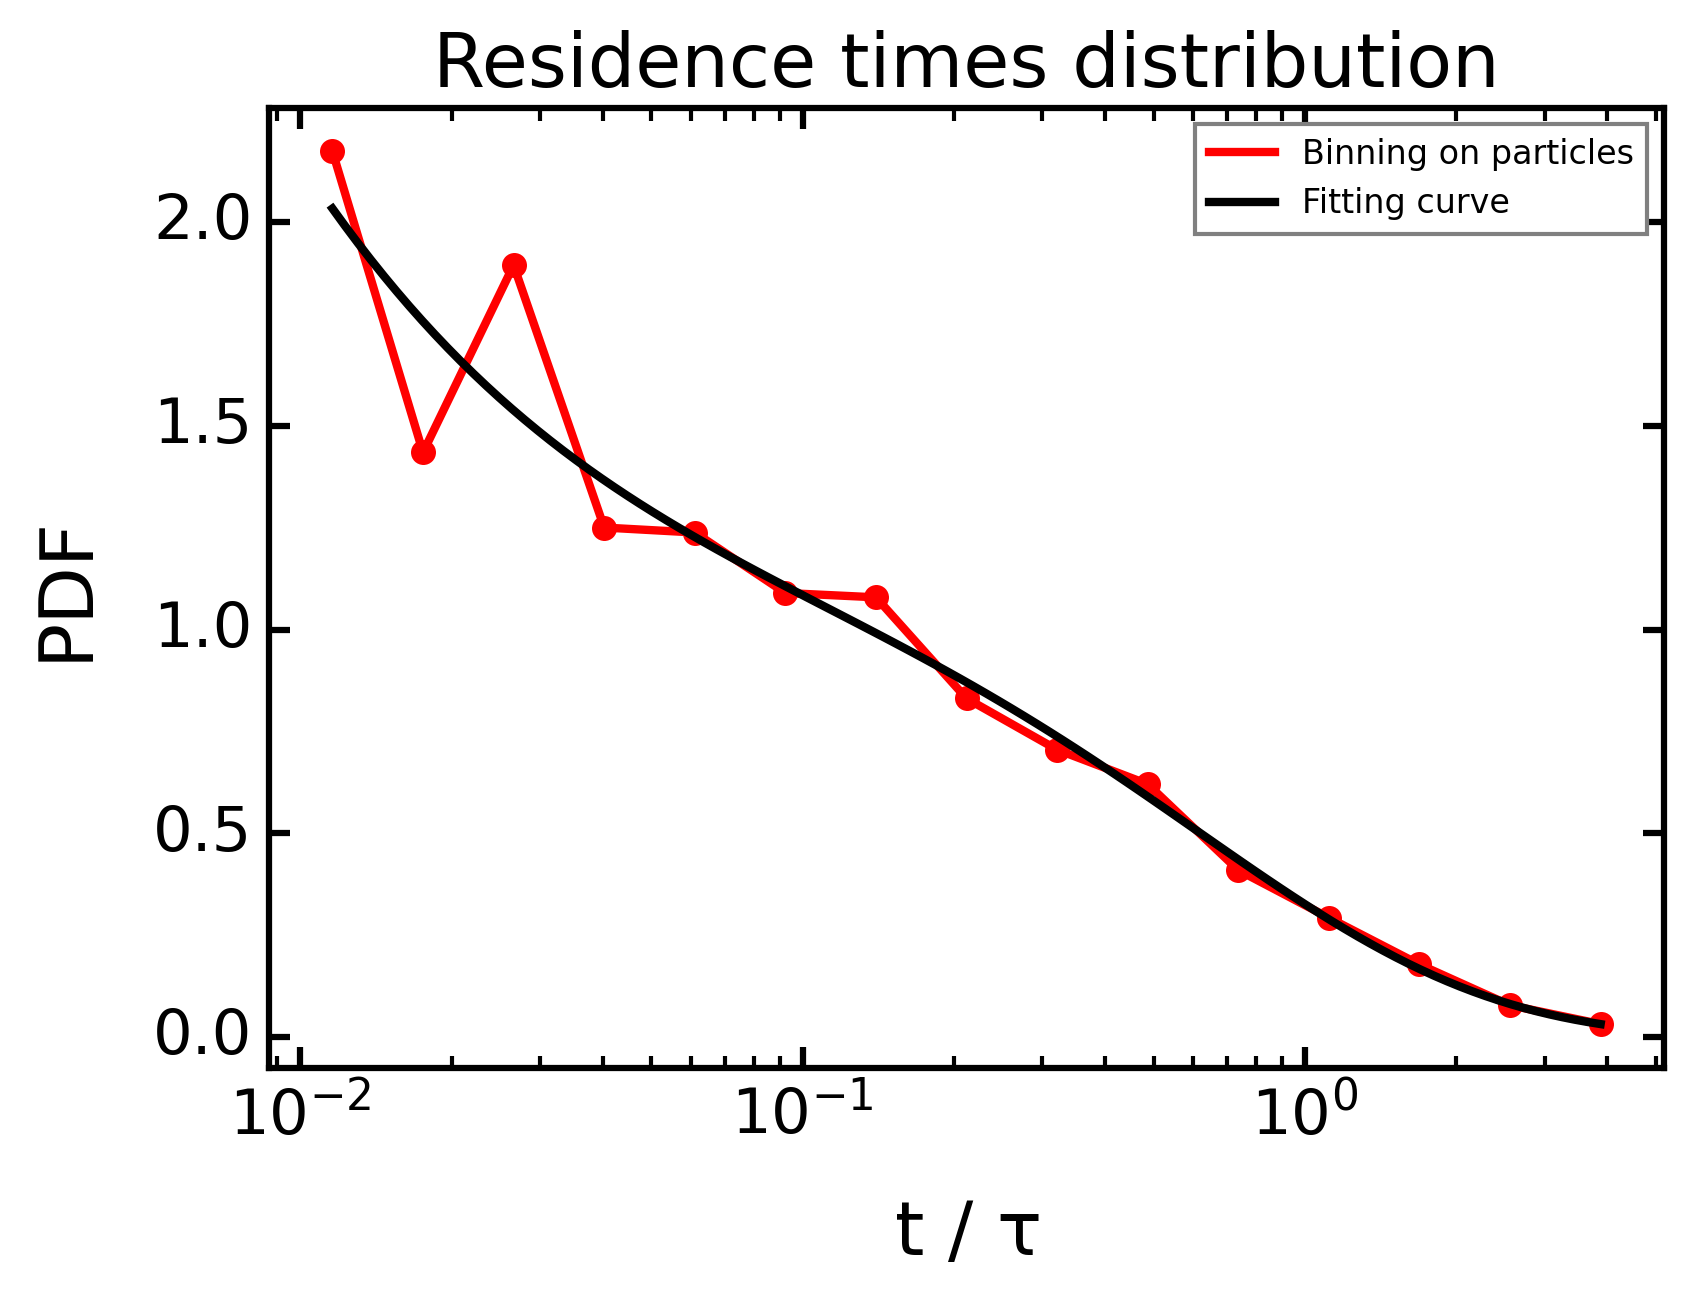

In [10]:

model_modflow = BV.preprocessing_modflow(for_calib=False)
success_modflow = BV.processing_modflow(model_modflow, write_model=True, run_model=True)

BV.postprocessing_modflow(model_modflow,
                          watertable_elevation = True,
                          watertable_depth= True, 
                          seepage_areas = True,
                          outflow_drain = True,
                          groundwater_flux = True,
                          groundwater_storage = True,
                          accumulation_flux = True,
                          persistency_index = False,
                          intermittency_monthly = False,
                          intermittency_daily = False,
                          export_all_tif = False)

BV.settings.update_input_particles(zone_partic = BV.geographic.watershed_dem,
                                    cell_div = part_num, # 1, distribution of partciles by cell in x and y direction
                                    zloc_div = False,  # False or True, inject partciles in z direction. Same number as cell_div
                                    bore_depth = None, # None or True, None 1 particle in the first layer, If True it will inject 1 particle in every layer.
                                    track_dir = tracking_dir, # backward or forward 
                                    sel_random = None, # or int
                                    sel_slice = None, # or int
                                    )

model_modpath = BV.preprocessing_modpath(model_modflow)
success_modpath = BV.processing_modpath(model_modpath, write_model=True, run_model=True)

BV.postprocessing_modpath(model_modpath,
                          ending_point=True,
                          starting_point=True,
                          pathlines_shp=True,
                          particles_shp=True,
                          random_id=None) # None

BV.filtprocessing_modpath(model_modpath,
                          norm_flux=True, # for forward only
                          filt_time=True, # delete particles with time at 0, add a column with time divided by 365 (considering recharge in days)
                          filt_seep=False, # only forward, keep only particles finishing in zone1 (seepage), keep only particles finishing in k1 (first layer)
                          filt_inout=True, # delete particles in and out in the same cell (first layer)
                          calc_rtd=True, # compute residence time distribution
                          random_id=None, # select randomly to keep
                          ) # None



In [11]:

# Load model
fname = simulations_folder+model_name+'/'+model_name
ml = flopy.modflow.Modflow.load(fname+'.nam')
hdobj = flopy.utils.HeadFile(fname + '.hds')
times = hdobj.get_times()

for i, t in enumerate([times[0]]):
    
    # Data
    i = int(i)
    head = hdobj.get_data(totim=t)
    
    # Figure
    fig = plt.figure(figsize=(10, 4), dpi=300)
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title('Cross-section : '+'time '+str(i))
    ax.set_xlabel('x [m]')
    ax.set_ylabel('z [m]')
    
    # Init cross-section
    xsect = flopy.plot.PlotCrossSection(model=ml, line={'Row': 0})
    
    # Head color
    pc = xsect.plot_array(head, masked_values=[999.], head=head, cmap='Blues',
                            vmin=0, vmax=None,
                          alpha=0.75)
    cb = plt.colorbar(pc, shrink=0.75)
    cb.set_label('Head [m]', labelpad=+10)
    wt = xsect.plot_surface(head, masked_values=[999.], color='b', lw=1)
    
    # Boundary
    patches = xsect.plot_ibound(head=head)
    
    # Grid
    linecollection = xsect.plot_grid(alpha=0.75, zorder=0)
    
    # # Particles plot
    end = gpd.read_file(simulations_folder+model_name+'/_postprocess/_particles/ending.shp')
    prt = gpd.read_file(simulations_folder+model_name+'/_postprocess/_particles/particles.shp')
    # list_particles = end[end['i0']==1]['particleid'].unique()
    ### Filtering if necessary
        # shp_fil = shp.copy()
        # shp_fil = shp[shp['zone']==1]
        # shp_fil = shp[shp['time']>1]
        # shp_fil = shp_fil[shp_fil['particleid'].isin(list_particles)]
    list_particles = [10,20,30,40,50,60,70,80,90,100]
    # prt_fil = prt[prt['particleid']==100]
    prt_fil =  prt[prt['particleid'].isin(list_particles)]
    sc = ax.scatter(prt_fil['x'], prt_fil['z'], c=prt_fil['time']/365, s=20, 
                    cmap='spring', linewidths=0, norm=mpl.colors.LogNorm(vmin=1/365, vmax=10))
    cbsc = plt.colorbar(sc, shrink=0.75)
    cbsc.set_label('Residence times [y]', labelpad=+10)
    
    # Adjust
    ax.set_ylim(0,thick*1.1)
    fig.tight_layout()



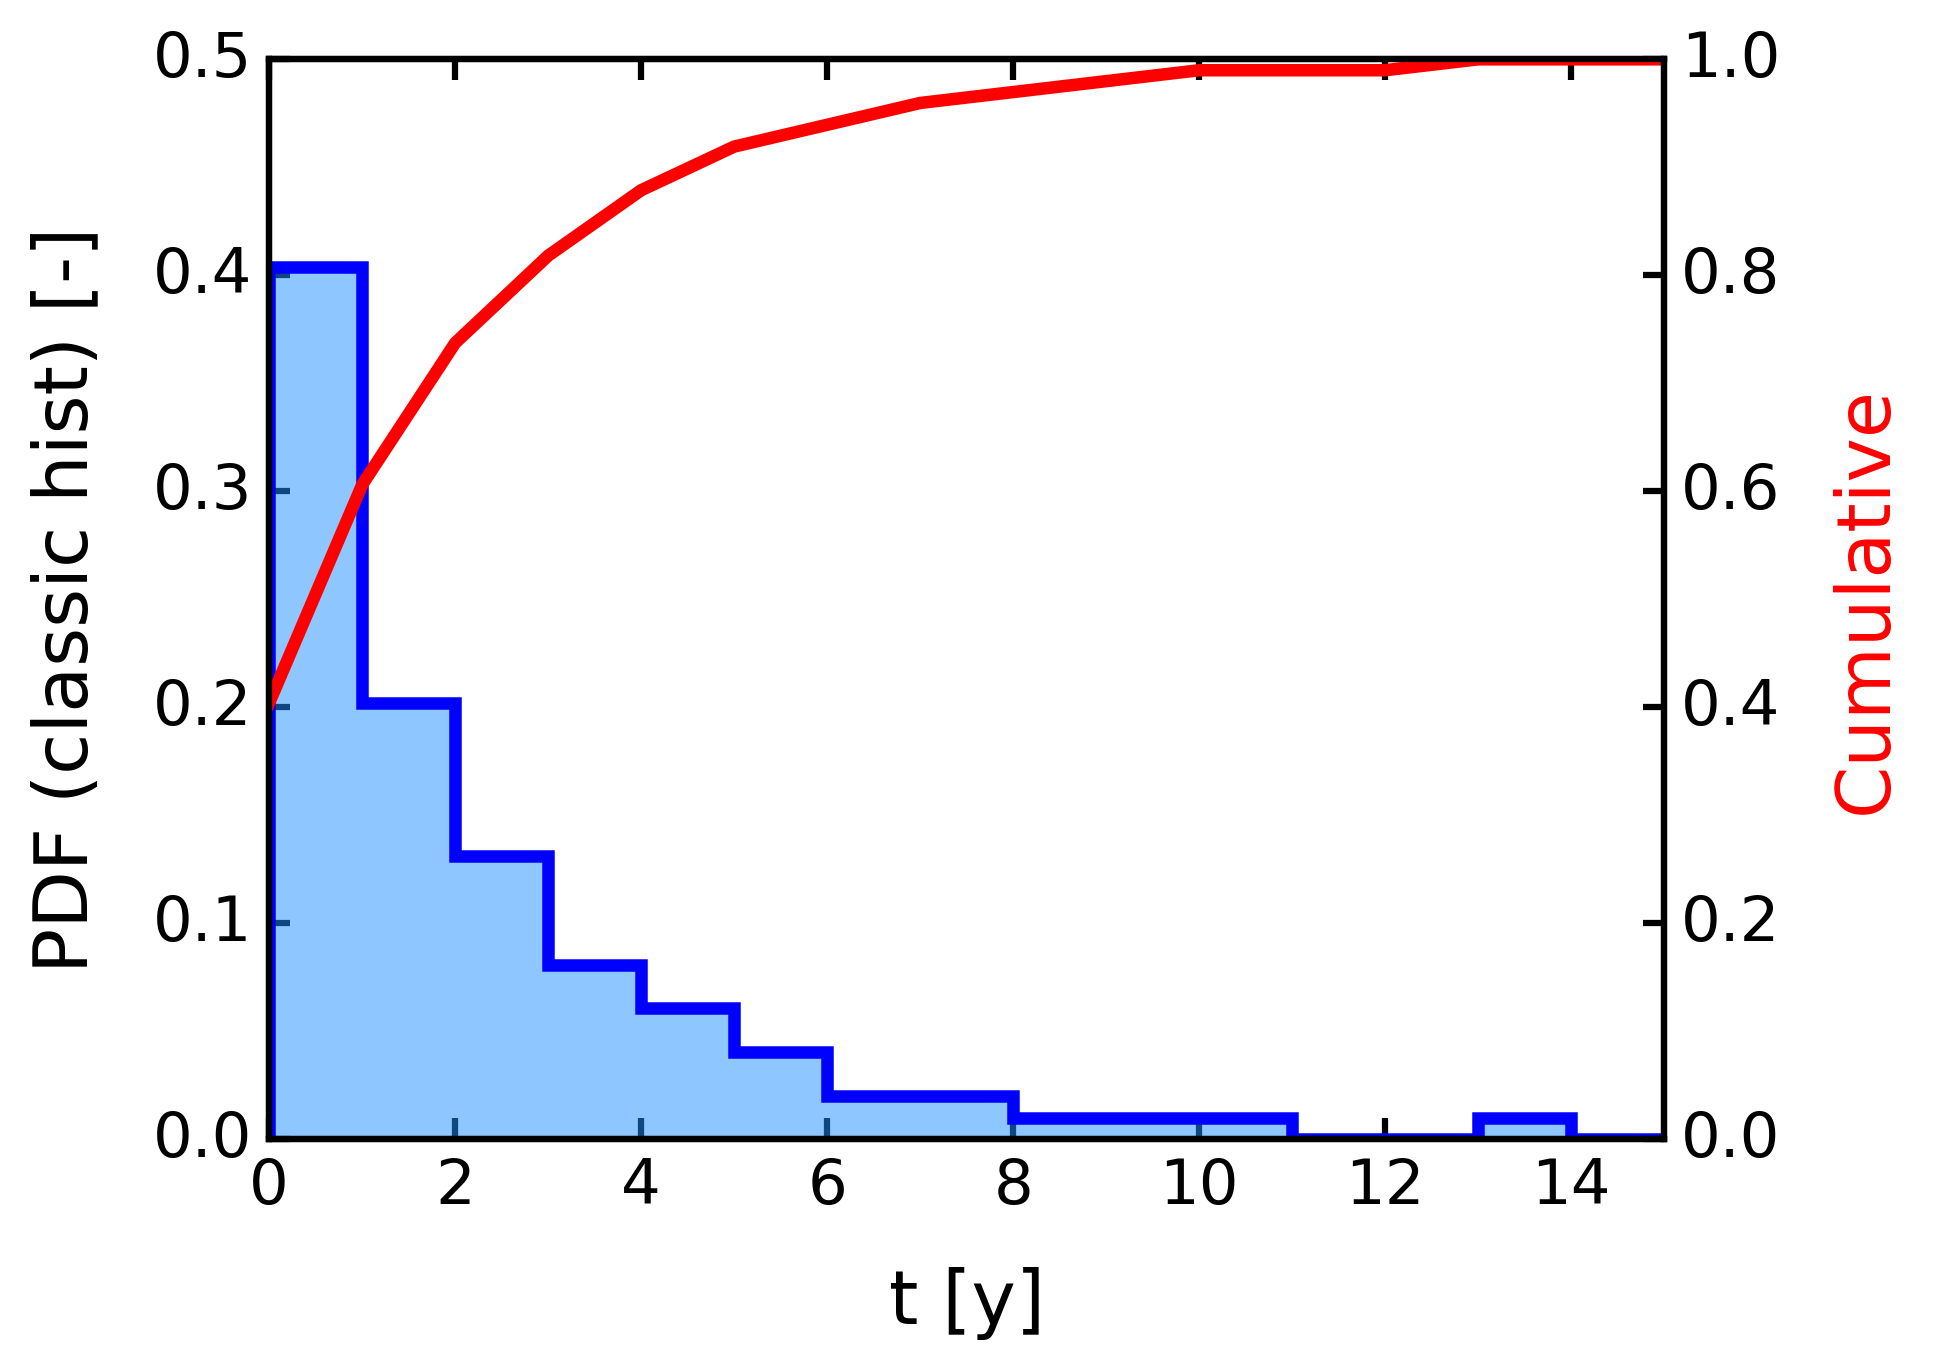

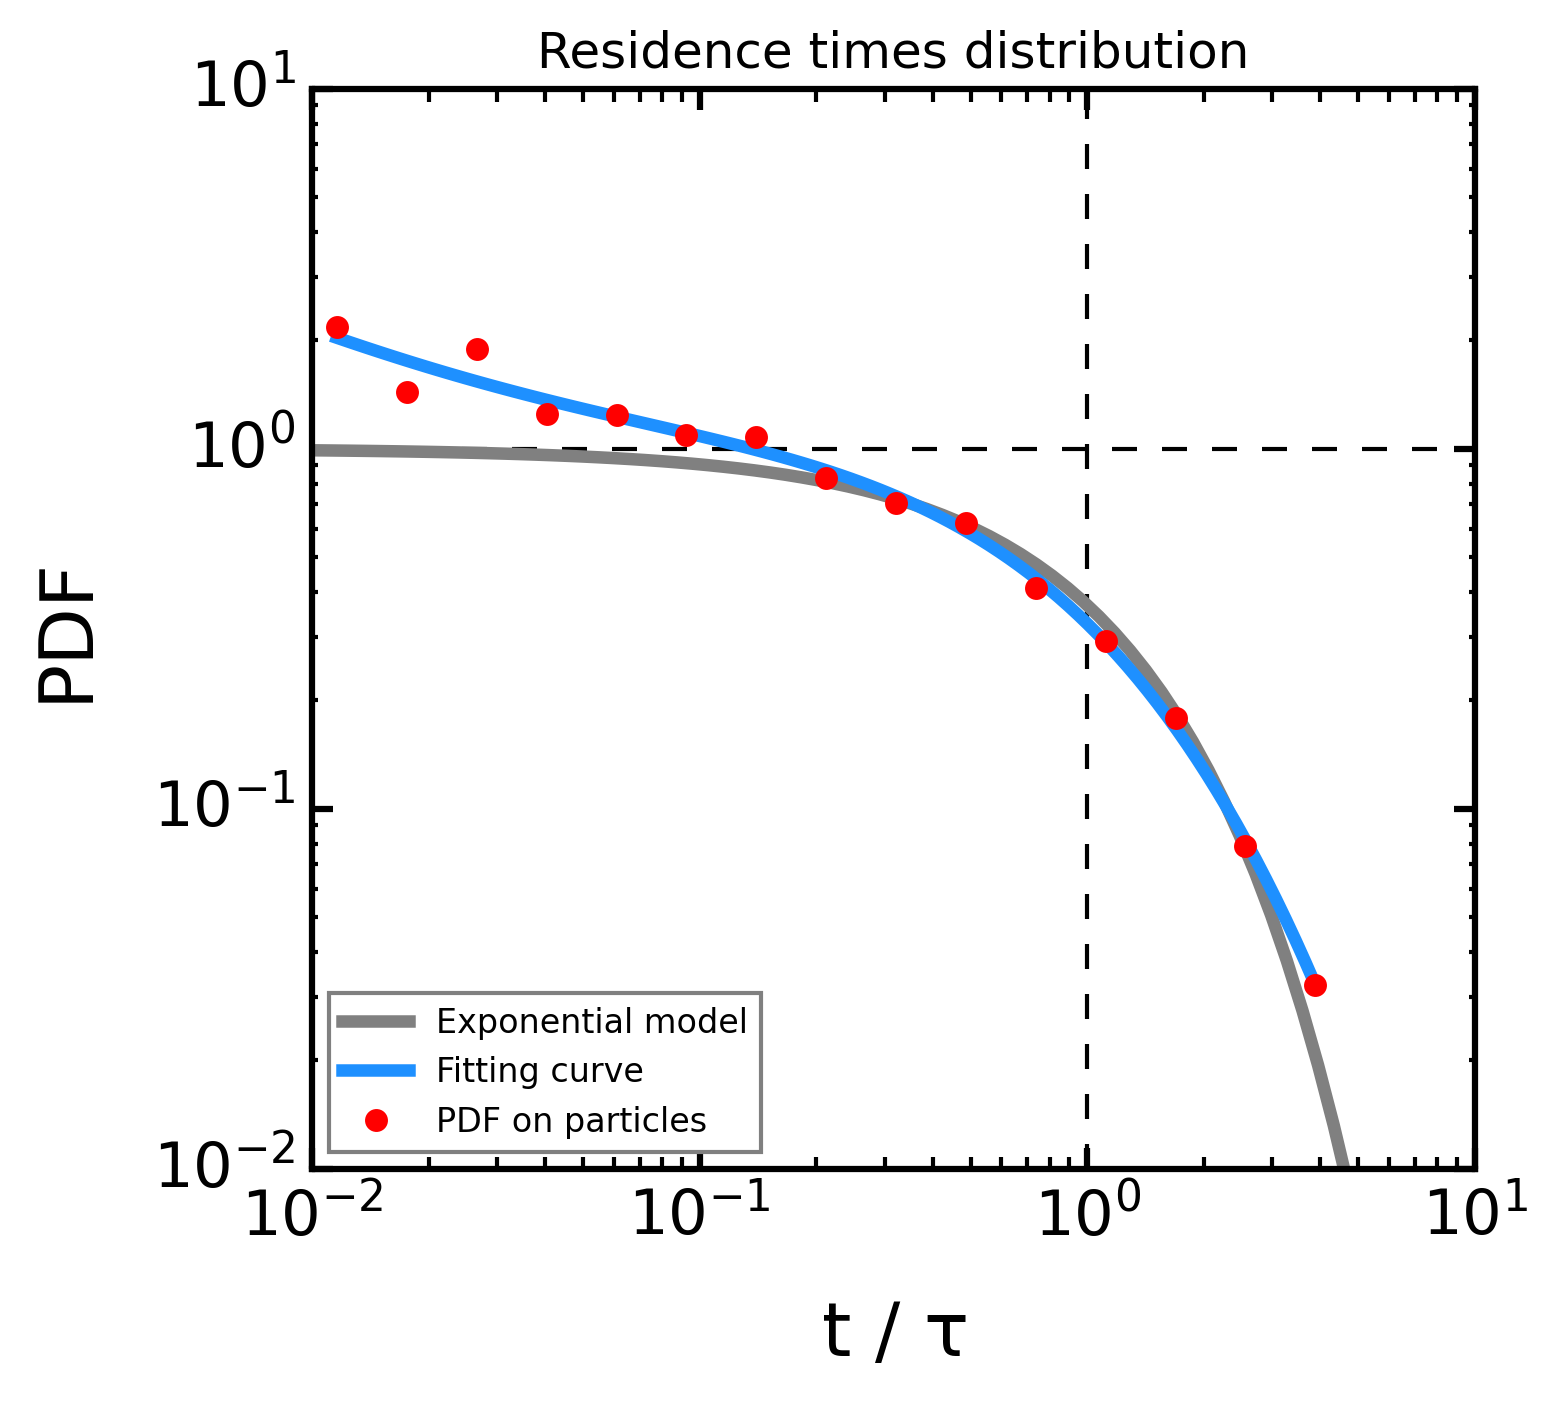

In [12]:

# Data
end = gpd.read_file(BV.geographic.simulations_folder+'/'+model_name+'/'+'_postprocess/_particles/'+'ending_weighted.shp')
end[end['time_win_y']==0] = np.nan
end = end.dropna()

# Tau
if tracking_dir == 'forward':
    tau = np.average(end['time_win_y'], weights=end['rchPerc'])
else:
    tau = np.average(end['time_win_y'])

# Pdf
def pdf_function(M, nbin, Weight):    
    bin_min = np.quantile(M, 0.01)
    bin_max = np.quantile(M, 0.99)
    bins = np.logspace(np.log10(bin_min),np.log10(bin_max), nbin)
    pdf, binEdges = np.histogram(M, bins=bins, density=True, weights=Weight)
    dx = np.diff(binEdges)  
    xh =  (binEdges[1:] + binEdges[:-1])/2
    xh = np.array(xh)
    return (xh, pdf)

# Bin
nbin = int(2*len(end['time_win_y'])**(2/5))          #Scott's Rules
if tracking_dir == 'forward':
    [xh, yh] = pdf_function(end['time_win_y']/tau, nbin, end['rchPerc'])
else:
    [xh, yh] = pdf_function(end['time_win_y']/tau, nbin, np.ones(len(end)))

# Log
idzeros = np.where(yh != 0)
xfil = xh[idzeros]
yfil = yh[idzeros]
x_log = np.log10(xfil)
y_log = np.log10(yfil)

# Fit
def func(x, a, b, c, d, e):
    return a * x**4 + b * x**3 + c * x**2 + d * x + e
params, covariance = curve_fit(func, x_log, y_log)
a, b, c, d, e = params
x_fit = np.linspace(min(x_log), max(x_log), 100)
y_fit = func(x_fit, a, b, c, d, e)

# PLot 1
fig = plt.figure(figsize=(6,4.5))
ax = fig.add_subplot(111)
axb = ax.twinx()
counts, bins = np.histogram(end['time_win_y'], density=True, weights=end['rchPerc'], bins=range(100))
ax.hist(end['time_win_y'], density=True, bins=range(100), weights=end['rchPerc'], facecolor='dodgerblue', alpha=0.5, lw=0)
ax.stairs(counts, bins, lw=3, color='b') # If the data has already been binned and counted, use bar or stairs to plot the distribution
ax.set_xlabel('t [y]')
ax.set_ylabel('PDF (classic hist) [-]')
ax.set_xlim(0, 15)
ax.set_ylim(0, 0.5)
axb.plot(bins[:-1], np.cumsum(counts), lw=3, ls='-', color='red')
axb.set_ylabel('Cumulative', color='red')
axb.set_ylim(0,1)

# Plot 2
fig = plt.figure(figsize=(5,4.5))
ax = fig.add_subplot(111)
tau2 = 1
t = np.logspace(-3, 1, 100)
p_ttd = 1/tau2*np.exp(-t/tau2)
ax.plot(t, p_ttd, 'grey', lw=3, label='Exponential model')
ax.plot(10**x_fit, 10**y_fit, '-', lw=3, c='dodgerblue', label='Fitting curve')
ax.plot(xh, yh, '.', lw=0, ms=10, c='red', label='PDF on particles')
intrp = np.interp(xh, t, p_ttd)        
ax.set_ylabel("PDF")
ax.set_xlabel("t / "+r'$\tau$')
ax.set_xscale('log')    
ax.set_yscale('log')
ax.set_title('Residence times distribution', fontsize=12)
ax.set_xlim(1e-2, 1e1)    
ax.set_ylim(1e-2, 1e1)
ax.axvline(x=1, c='k', ls='--', zorder=-1)
ax.axhline(y=1, c='k', ls='--', zorder=-1)
ax.legend(loc='lower left')



In [13]:

# wbt.verbose = True
# wbt.resample(
#     dem_path_ref, 
#     dem_path_res, 
#     cell_size=100, 
#     base=None, 
#     method="cc")

# bx = fig.add_subplot(212)
# erro = (intrp - xh)/intrp * 100        # error calculus (teo - obs)/teo
# rms = np.sqrt(np.mean(erro**2))        # rms calculus
# bx.plot(xh, erro, 'o', label = 'RMS = '+ str(round(rms, 2)))
# bx.legend()
# bx.set_ylim(-100, 100)
# bx.set_xscale('log')
# bx.set_xlim(5e-3, 1.5e1)
# bx.set_xlim(0.5e-3, 1.5e1)
